<a href="https://colab.research.google.com/github/laurencefrank/Applied-Text-Mining/blob/main/ATM_P4_Tuesday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applied Text Mining, Utrecht Summerschool 26 - 29 July 2021

Tuesday 27 July, practical 4

### Practical 4: Text Clustering and Topic Modeling¶


Welcome to the fourth practical of the course “Applied Text Mining”. In this practical, we are going to apply different clustering algorithms and a topic modeling approach on sport news articles and cluster them into different categories.

Today we will use the following libraries. Take care to have them installed!

In [4]:
from sklearn.datasets import load_files
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from sklearn import metrics

from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

# for reproducibility
SEED = 321 

1. Here we are going to use a another set of the BBC news articles, the BBCSport data (http://mlg.ucd.ie/datasets/bbc.html). This data set provided for use as benchmarks for machine learning research. The BBCSport data set consists of 737 documents from the BBC Sport website corresponding to sports news articles from 2004-2005 in five topical areas: athletics, cricket, football, rugby, tennis. Your first task is to load the data set so that you can proceed. Do not forget to import the necessary dependencies, you are going to need. You can import the other ones as you go along.

In [5]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/AppliedTextMiningSummerschoolUtrechtJuly2021/bbcsport-fulltext/bbcsport"
data = load_files(DATA_DIR, encoding="utf-8", decode_error="replace", random_state=SEED)
df = pd.DataFrame(list(zip(data['data'], data['target'])), columns=['text', 'label'])
df.head()

,text,label
0,"Scotland v Italy (Sat)\n\nMurrayfield, Edinbur...",3
1,Wales silent on Grand Slam talk\n\nRhys Willia...,3
2,Arsenal 1-1 Sheff Utd\n\nAndy Gray's 90th-minu...,2
3,Cole refuses to blame van Persie\n\nAshley Col...,2
4,Van Nistelrooy hungry for return\n\nManchester...,2


In [6]:
labels, counts = np.unique(df['label'], return_counts=True)
print(dict(zip(data.target_names, counts)))

{'athletics': 101, 'cricket': 124, 'football': 265, 'rugby': 147, 'tennis': 100}


In [7]:
data.target_names

['athletics', 'cricket', 'football', 'rugby', 'tennis']

2. For text clustering and topic modeling, we will ignore the labels but we will use them while evaluating models. Create a copied dataframe removing the outcome variable.

In [8]:
bbcsport_text = pd.DataFrame(df['text'])
bbcsport_text.head()

,text
0,"Scotland v Italy (Sat)\n\nMurrayfield, Edinbur..."
1,Wales silent on Grand Slam talk\n\nRhys Willia...
2,Arsenal 1-1 Sheff Utd\n\nAndy Gray's 90th-minu...
3,Cole refuses to blame van Persie\n\nAshley Col...
4,Van Nistelrooy hungry for return\n\nManchester...


3. Apply the following pre-processing steps and then convert the data to a dataframe of document-term matrix with term frequencies:


* convert to lower
* remove stop words
* remove numbers
* extract uni- and bi-grams
* remove terms that occur in less than 2 documents
* remove one-letter terms, e.g.'a', or 's'



In [9]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   lowercase=True,
                                   min_df=2,
                                   ngram_range=(1,2), 
                                   token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b')
tfidf_vectorizer.fit(df.text.values)
tfidf_matrix = tfidf_vectorizer.transform(df.text.values)
tfidf_matrix.shape

(737, 21604)

In [10]:
tfidf_vectorizer.vocabulary_

{'scotland': 16588,
 'italy': 9554,
 'sat': 16416,
 'murrayfield': 12483,
 'edinburgh': 5500,
 'saturday': 16420,
 'february': 6375,
 'gmt': 7592,
 'live': 10930,
 'website': 20649,
 'victory': 20246,
 'azzurri': 1162,
 'rome': 15819,
 'year': 21407,
 'saw': 16453,
 'end': 5635,
 'campaign': 2428,
 'pressure': 14463,
 'coach': 3334,
 'matt': 11818,
 'williams': 20857,
 'seeks': 16838,
 'nations': 12557,
 'eighth': 5541,
 'attempt': 990,
 'lost': 11181,
 'opening': 13151,
 'games': 7288,
 'home': 8678,
 'ireland': 9450,
 'wales': 20390,
 'travel': 19657,
 'high': 8536,
 'hopes': 8748,
 'john': 9743,
 'kirwan': 10230,
 'warned': 20519,
 'errors': 5894,
 'blighted': 1816,
 'loss': 11173,
 'risk': 15689,
 'suffering': 18370,
 'successive': 18351,
 'defeat': 4554,
 'taught': 18702,
 'level': 10734,
 'make': 11412,
 'mistakes': 12256,
 'said': 16105,
 'error': 5893,
 'come': 3435,
 'price': 14500,
 'aggressive': 313,
 'minutes': 12165,
 'calm': 2377,
 'situation': 17385,
 'display': 5042,
 '

## K-Means clustering

4. Let’s apply a K-Means clustering algorithm. Since the data set contains articles that belong to one of the 5 categories, you may want to choose 5 as the number of clusters. But not always you have such information about your data. Tip: Use the MiniBatchKMeans function from the sklearn package.

In [12]:
n_clusters = 5
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=SEED)
cls.fit(tfidf_matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=321,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

5. What are the top terms in each cluster?

In [13]:
print("Top terms per cluster:")

order_centroids = cls.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s/' % terms[ind], end='')
    print()
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

Top terms per cluster:
Cluster 0: cricket/ pakistan/ series/ australia/ test/ india/ sri/ day/ zealand/ new zealand/
Cluster 1: england/ south/ vaughan/ south africa/ africa/ test/ strauss/ jones/ overs/ day/
Cluster 2: said/ chelsea/ club/ united/ arsenal/ game/ league/ cup/ liverpool/ players/
Cluster 3: olympic/ indoor/ holmes/ race/ world/ champion/ athletics/ athens/ european/ marathon/
Cluster 4: england/ wales/ ireland/ rugby/ france/ nations/ robinson/ half/ scotland/ coach/


Based on these 10 top terms we can manually label our clustering output as:

* cluster 0: cricket
* cluster 1: tennis
* cluster 2: football
* cluster 3: athletics
* cluster 4: rugby

6. Visualize the output of the K-Means clustering: first apply a PCA method to transform the high-dimensional feature space into 2 dimensions, and plot the points using a scatter plot.

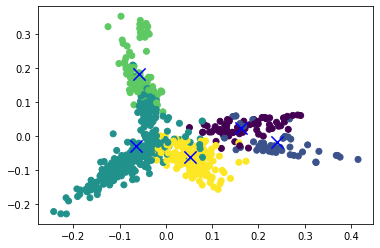

In [15]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=SEED)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(tfidf_matrix))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

7. Evaluate the quality of the K-Means clustering with the sklearn metrics for clustering: homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score.

Evaluation for unsupervised learning algorithms is a bit difficult and requires human judgement but there are some metrics which you might use. There are two kinds of metrics you can use depending on whether or not you have the labels.

If you have a labelled data set you can use metrics that give you an idea of how good your clustering model is. For this purpose you can use the sklearn.metrics module, for example `homogeneity_score` is one of the possible metrics. As per the documentation, the score ranges between 0 and 1 where 1 stands for perfectly homogeneous labeling.

If you do not have labels for your data set, then you can still evaluate your clustering model with some metrics. One of them is Silhouette Coefficient. From the sklearn's documentation: The Silhouette Coefficient is calculated using the mean intra-cluster distance ($a$) and the mean nearest-cluster distance ($b$) for each sample. The Silhouette Coefficient for a sample is $(b - a) / max(a,b)$. To clarify, $b$ is the distance between a sample and the nearest cluster that the sample is not a part of. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [16]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(data.target, cls.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(data.target, cls.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(data.target, cls.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(data.target, cls.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tfidf_matrix, cls.labels_, sample_size=1000))

Homogeneity: 0.668
Completeness: 0.784
V-measure: 0.722
Adjusted Rand-Index: 0.600
Silhouette Coefficient: 0.014


8. Apply the K-Means clustering method on a range of 3 to 7 clusters, and calculate the squared loss obtained in each clustering. Apply the Elbow method to find the optimal k. (Tip: use the cls.inertia_ for the squared loss. Try other metrics as well)

In [18]:
num_clus = [x for x in range(3, 7)]
squared_errors = []
for cluster in num_clus:
    cls = MiniBatchKMeans(n_clusters=cluster, random_state=SEED)
    cls.fit(tfidf_matrix) # Train Clusters
    squared_errors.append(cls.inertia_) # Appending the squared loss obtained in the list

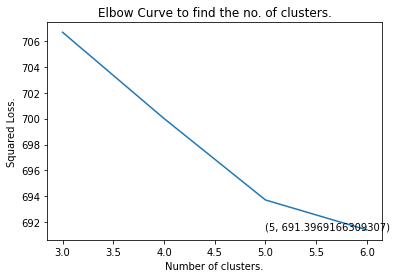

The optimal number of clusters obtained is -  5
The loss for optimal cluster is -  691.3969166309307


In [20]:
# https://www.kaggle.com/karthik3890/text-clustering
# Choosing the best cluster using Elbow Method.
# source credit,few parts of min squred loss info is taken from different parts of the stakoverflow answers.
# this is used to understand to find the optimal clusters in differen way rather than used in BOW, TFIDF

num_clus = [x for x in range(3, 7)]
squared_errors = []
for cluster in num_clus:
    cls = MiniBatchKMeans(n_clusters=cluster, random_state=SEED)
    cls.fit(tfidf_matrix) # Train Clusters
    squared_errors.append(cls.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))


9. Use the following two news articles as your test data, and predict cluster labels for your new data set with the best value for K and the K-Means algorithm.

In [23]:
documents = ['Frank de Boer out as Oranje manager after early Euro 2020 exit Dutch men’s football team coach.',
             'The time has come for Nadal to be selective in the events that he should and should not play. This is where he can start the difficulty. After a rigorous participation of the clay season, Rafael Nadal definitely wants to conserve his energies for as long as possible.']

In [21]:
n_clusters = 5
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=SEED)
cls.fit(tfidf_matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=321,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [24]:
tfidf_test = tfidf_vectorizer.transform(documents)
tfidf_test.shape

(2, 21604)

In [25]:
print(cls.predict(tfidf_test))

[2 2]


## Hierarchical clustering

10. Hierarchical clustering is a type of unsupervised machine learning algorithm used to cluster unlabeled data points. Similar to the K-Means clustering, hierarchical clustering groups together the data points with similar characteristics. Apply the hierarchical clustering with the ward linkage on the Sports news data set. Fit the model with 5 clusters and check the predicted labels.

In [26]:
cls2 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cls2 = cls2.fit(tfidf_matrix.toarray())

In [27]:
cls2.labels_

array([4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 4, 1, 0, 2, 2, 2, 0, 2,
       2, 1, 2, 2, 4, 0, 1, 0, 4, 2, 2, 1, 2, 1, 0, 2, 4, 0, 0, 0, 1, 2,
       2, 0, 0, 2, 1, 4, 2, 2, 0, 1, 2, 2, 0, 4, 4, 1, 2, 1, 2, 1, 2, 1,
       2, 1, 0, 0, 1, 0, 2, 3, 4, 0, 1, 4, 2, 0, 0, 4, 2, 2, 4, 4, 2, 2,
       1, 0, 4, 4, 2, 0, 0, 0, 2, 4, 1, 2, 2, 1, 4, 2, 2, 2, 0, 0, 1, 1,
       4, 4, 2, 1, 2, 2, 0, 0, 2, 3, 2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0,
       4, 2, 1, 2, 4, 2, 2, 2, 2, 4, 2, 4, 0, 0, 4, 2, 2, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 2, 0, 4, 0, 4, 1, 1, 0, 0, 4, 2, 2, 1, 1, 4, 2, 1, 2,
       2, 0, 4, 2, 0, 2, 4, 4, 1, 0, 1, 2, 1, 0, 0, 0, 0, 2, 4, 3, 2, 2,
       0, 4, 1, 1, 1, 2, 2, 1, 1, 4, 1, 4, 2, 1, 2, 2, 2, 1, 4, 1, 2, 2,
       2, 2, 2, 4, 2, 0, 1, 4, 4, 1, 0, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 0, 2, 4, 2, 2, 2, 1, 4, 1, 0, 2, 4, 0, 2, 1, 0,
       0, 0, 4, 2, 2, 0, 2, 0, 0, 2, 4, 2, 0, 0, 4,

11. Plot a dendrogram for your hierarchical clustering model using the function below. To do this, you need to fit the model again without assigning the number of clusters.

In [28]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

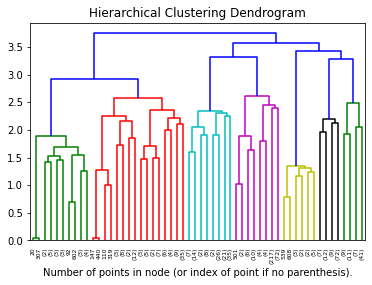

In [29]:
# setting distance_threshold=0 ensures we compute the full tree.
cls2 = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=0)
cls2 = cls2.fit(tfidf_matrix.toarray())

plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(cls2, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

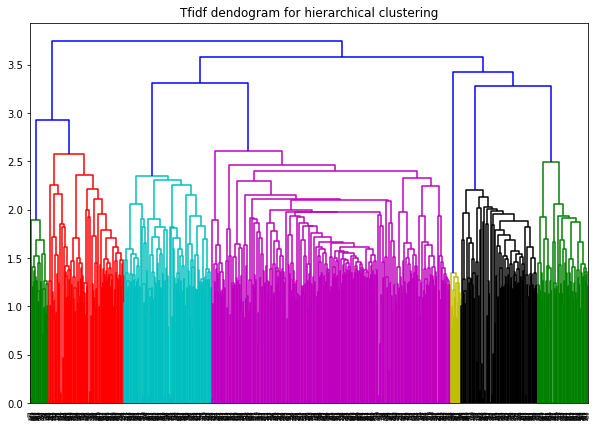

In [30]:
# here is another way of plotting the hc using the scipy library 
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Tfidf dendogram for hierarchical clustering")
dend = shc.dendrogram(shc.linkage(tfidf_matrix.toarray(), method='ward'))

## Topic modeling

Topic modeling is another unsupervised method for text mining applications where we want to get an idea of what topics we have in our data set. A topic is a collection of words that describe the overall theme. For example, in case of news articles, you might think of topics as the categories in the data set. Just like clustering algorithms, there are some algorithms that need you to specify the number of topics you want to extract from the data set and some that automatically determine the number of topics. Here, we are going to use the Non-Negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA) methods for topic modeling. You can check sklearn's documentation for more details about NMF and LDA. They are available in sklearn.decomposition module.

12. Train a NMF model for topic modeling on a tf-based document-term matrix of the BBCSport data set.

In [32]:
# number of topics to extract
n_topics = 5

nmf = NMF(n_components=n_topics, random_state=SEED)
nmf.fit(tfidf_matrix)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=321, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

13. Show top 10 words per topic with their probabilities.

In [33]:
for i, topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['champions league', 'cup', 'said', 'mourinho', 'club', 'liverpool', 'united', 'league', 'arsenal', 'chelsea']


Top 10 words for topic #1:
['england', 'africa', 'india', 'south africa', 'day', 'south', 'series', 'pakistan', 'cricket', 'test']


Top 10 words for topic #2:
['olympic', 'final', 'seed', 'set', 'race', 'indoor', 'year', 'champion', 'open', 'world']


Top 10 words for topic #3:
['game', 'scotland', 'half', 'nations', 'france', 'rugby', 'robinson', 'ireland', 'wales', 'england']


Top 10 words for topic #4:
['charges', 'athletics', 'olympics', 'doping', 'athens', 'drugs', 'iaaf', 'thanou', 'greek', 'kenteris']




You can again try to manually label these extracted topics.

14. Use the NMF model and identify the topic (or cluster) of the new texts in the documents object. Simply call the transform function of the model and it will give you a score of each topic. Choose the topic with the highest score to determine documents' topics.

In [34]:
# first transform the text into features using tfidf_vectorizer then pass it to transform of nmf
# the result will be a matrix of shape [2, 10] then we sort the topic id based on the score using argsort
# and take the last one (with the highest score) for each row using `[:,-1]` indexing
print(nmf.transform(tfidf_vectorizer.transform(documents)))
nmf.transform(tfidf_vectorizer.transform(documents)).argsort(axis=1)[:,-1]

[[0.03102346 0.00036267 0.01099815 0.00809537 0.00311989]
 [0.01549877 0.00264124 0.03429618 0.00092925 0.        ]]


array([0, 2])

The first document is allocated to topic one (highest probability = 0.031), which is football (correct)
The second document has the highest probability for the third topic (prob. = 0.03), which represents tennis (correct).

15. The other mainly used approach for topic modeling is Latent Dirichlet Allocation (LDA). The LDA is based upon two general assumptions:

* Documents exhibit multiple topics
* A topic is a distribution over a fixed vocabulary

Train a LDA model from the sklearn package for topic modeling with 5 components.

In [35]:
LDA = LatentDirichletAllocation(n_components=5, random_state=SEED, evaluate_every=10)
LDA.fit(tfidf_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=10, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=321, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

We used LDA to create topics along with the probability distribution for each word in our vocabulary for each topic. The parameter n_components specifies the number of categories, or topics, that we want our text to be divided into.

16. Print the 10 words with highest probabilities for all the five topics.

In [36]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['play', 'cup', 'players', 'team', 'win', 'world', 'year', 'game', 'england', 'said']


Top 10 words for topic #1:
['maurice', 'holmes', 'capriati', 'mauresmo', 'isinbayeva', 'sharapova', 'greene', 'lewis francis', 'francis', 'mirza']


Top 10 words for topic #2:
['gregory lamboley', 'imanol', 'half replacement', 'valbon', 'harinordoquy', 'stade', 'bortolami', 'bourgoin', 'toulousain', 'stade toulousain']


Top 10 words for topic #3:
['tribunal', 'charges', 'balco', 'conte', 'drugs', 'doping', 'thanou', 'greek', 'iaaf', 'kenteris']


Top 10 words for topic #4:
['money women', 'rod', 'aus', 'ind', 'pattaya', 'prize money', 'kafer', 'martinez', 'umaga', 'hingis']




You can also use the following function for this purpose:

In [38]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [40]:
no_top_words = 10
display_topics(LDA, tfidf_vectorizer.get_feature_names(), no_top_words=10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,said,21.1,mirza,2.2,stade toulousain,1.0,kenteris,3.5,hingis,1.0
1,england,18.2,francis,2.0,toulousain,1.0,iaaf,3.1,umaga,1.0
2,game,13.8,lewis francis,2.0,bourgoin,0.6,greek,3.1,martinez,0.9
3,year,13.6,greene,1.7,bortolami,0.6,thanou,3.1,kafer,0.8
4,world,12.6,sharapova,1.3,stade,0.6,doping,2.5,prize money,0.7
5,win,12.3,isinbayeva,1.2,harinordoquy,0.6,drugs,2.3,pattaya,0.7
6,team,11.9,mauresmo,1.0,valbon,0.5,conte,2.2,ind,0.7
7,players,11.5,capriati,1.0,half replacement,0.4,balco,1.8,aus,0.7
8,cup,11.4,holmes,1.0,imanol,0.4,charges,1.5,rod,0.6
9,play,11.4,maurice,1.0,gregory lamboley,0.4,tribunal,1.4,money women,0.6


17. Transform the learned topics into your data. Check the shape of the output. What can be the use of this output?

In [41]:
topic_values = LDA.transform(tfidf_matrix)
topic_values.shape

(737, 5)

In [42]:
topic_values

array([[0.95297704, 0.01175449, 0.01175873, 0.01175444, 0.01175529],
       [0.94455696, 0.01385469, 0.01387983, 0.0138542 , 0.01385432],
       [0.94949035, 0.01264149, 0.01261802, 0.01263226, 0.01261788],
       ...,
       [0.92571628, 0.01857336, 0.01856985, 0.01857083, 0.01856967],
       [0.4823713 , 0.48677254, 0.01028672, 0.01028405, 0.0102854 ],
       [0.363303  , 0.01191515, 0.60094594, 0.01191983, 0.01191608]])

This output can be used as our new observations and features for further tasks.

First select the best number of topics using different methods (NMF, LDA, with different number of topics).
Then, add the topics of the best solution as features to your document-feature matrix. Then use a classifier to perform the prediction task. 


18. Use the score function for LDA to calculate the log likelihood for your data. Compare two LDA models with 5 and 10 topics.

In [43]:
LDA10 = LatentDirichletAllocation(n_components=10, random_state=321, evaluate_every=10)
LDA10.fit(tfidf_matrix)
print("The log likelihood for the LDA model with 5 topics:", LDA.score(tfidf_matrix))
print("The log likelihood for the LDA model with 10 topics:", LDA10.score(tfidf_matrix))

The log likelihood for the LDA model with 5 topics: -91498.09007139166
The log likelihood for the LDA model with 10 topics: -106388.86181536071


Many procedures use the log of the likelihood, rather than the likelihood itself, because it is easier to work with. The log likelihood (i.e., the log of the likelihood) will always be negative, with higher values (closer to zero) indicating a better fitting model. Here this belongs to the model with 5 topics.